In [3]:
import numba
from numba import cuda
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
imgrows = 2**10
imgcols = 2**10
BATCH = 128

In [5]:
@cuda.jit
def slow_kernel(inputImage, kernel, outputImage, channels, w, h, kernelRows, kernelCols):
    r, c = cuda.grid(2) # Finding the global position of the thread
    kernelRowsRadius = kernelRows//2
    kernelColsRadius = kernelCols//2
    for b in range(BATCH):
        for ch in range(channels):
            opPixel = 0
            if r < h and c < w:
                startRow = r - kernelRowsRadius
                startCol = c - kernelColsRadius
                for i in range(kernelRows):
                    for j in range(kernelCols):
                        currentRow = startRow + i
                        currentCol = startCol + j
                        if currentRow >= 0 and currentRow < h and currentCol >= 0 and currentCol < w:
                            opPixel += inputImage[b, currentRow, currentCol, ch]*kernel[i, j]
            outputImage[b,r,c,ch] = opPixel

In [6]:
img = cv2.imread('peacock.jpg')
img = cv2.resize(img, (imgrows, imgcols))
img_batch = []
for i in range(BATCH):
    img_batch.append(img)
img_batch = np.array(img_batch)
threadsperblock = (16, 16)
blockspergrid = (np.ceil(imgrows/threadsperblock[0]).astype('int'), np.ceil(imgcols/threadsperblock[1]).astype('int'))
print (threadsperblock)
print (blockspergrid)

(16, 16)
(64, 64)


In [7]:
## Average
kernelwidth =  3
kernelheight = 3
kernel = np.ones((kernelwidth,kernelheight))
kernel /= kernelheight*kernelwidth

### Laplacian
# kernel = np.array([[-1,-1,-1], [-1, 8 ,-1],[-1,-1,-1]]) 

### sharpen
# kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) 

# Edge detection
# kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]]) 


In [8]:
# stream = cuda.stream()
# start = time.time()
# with stream.auto_synchronize():
channels = 3
start = cuda.event(timing = True)
stop = cuda.event(timing = True)
inputImageGlobalMemory = cuda.to_device(img_batch)
kernelGlobalMemory = cuda.to_device(kernel)
outputImageGlobalMemory = cuda.device_array((BATCH ,imgrows, imgcols, channels))
slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,channels, imgrows, imgcols, kernelwidth, kernelheight)
outputImage = outputImageGlobalMemory.copy_to_host()
# To make executions async and when python exits the context
# syncronization happens

In [9]:
start.record()
slow_kernel[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols, kernelwidth, kernelheight)
stop.record()

outputImage = outputImageGlobalMemory.copy_to_host()
print (start.elapsed_time(stop)*1e-3)


0.43187301635742187


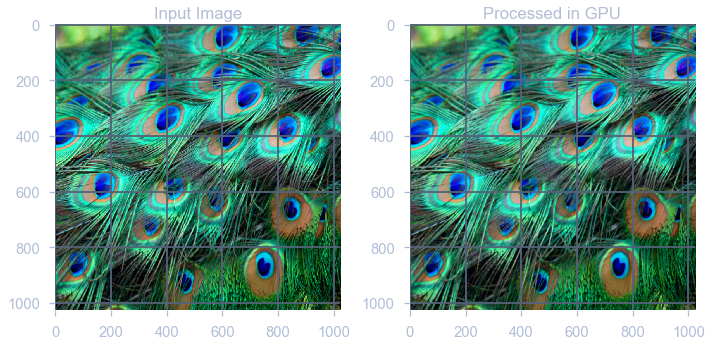

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(outputImage[0][:,:,::-1].astype('uint8'))
plt.title("Processed in GPU")
plt.tight_layout()
plt.show()

In [11]:
start = time.time()
op_image = []
for i in range(BATCH):
    op_image.append(cv2.filter2D(img_batch[i],-1,kernel))
print (time.time() - start)

1.8251118659973145


In [66]:
cv2.imwrite("output.jpg", outputImage.astype('int'))
cv2.imwrite("input.jpg", img)

True

In [78]:
KERNEL = 3
O_TILE_WIDTH = 8
BLOCK_WIDTH =  O_TILE_WIDTH + KERNEL - 1
CHANNEL = 3

In [79]:
# ### Average
kernel = np.ones((KERNEL,KERNEL))
kernel /= KERNEL*KERNEL

## Laplacian
# kernel = np.array([[-1,-1,-1], [-1, 8 ,-1],[-1,-1,-1]]) 

### sharpen
# kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]) 

# Edge detection
# kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]]) 


In [80]:
@cuda.jit
def shared_conv(inputImage, kernel, outputImage, channels, w, h):
    
    Ns = cuda.shared.array(shape=(BLOCK_WIDTH, BLOCK_WIDTH), dtype=numba.uint8)
    
    r, c  = cuda.grid(2)
    KERNEL_RADIUS = KERNEL//2
    
    # Need to load cooperatively [blockDim.x + Kernelrowradius , blockDim.y + Kernelcolsradius]
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    # Calculating the output tile's row and col coordinates
    row_o = cuda.blockIdx.y*O_TILE_WIDTH + ty
    col_o = cuda.blockIdx.x*O_TILE_WIDTH + tx
    
    # Shifting the coordinate system to corresponding input tile 
    row_i = row_o - KERNEL_RADIUS
    col_i = col_o - KERNEL_RADIUS
    
    output = 0.0
    
    # Taking care of boundaries
    if (row_i >= 0 and row_i < h and col_i >=0  and col_i < w):
        Ns[ty][tx] = inputImage[row_i, col_i]
    else:
        Ns[ty][tx] = 0
    
    # Some threads do not participate in calclating the output
    if (ty < O_TILE_WIDTH and tx < O_TILE_WIDTH):
        for i in range(KERNEL):
            for j in range(KERNEL):
                output+= Ns[i+ty][j+tx]*kernel[i][j]
        if row_o < w and col_o < h:
            outputImage[row_o, col_o] = output
    

In [81]:
@cuda.jit
def shared_conv_color(inputImage, kernel, outputImage, channels, w, h):
    
    Ns = cuda.shared.array(shape=(BATCH, BLOCK_WIDTH, BLOCK_WIDTH, CHANNEL), dtype=numba.uint8)
    
    r, c  = cuda.grid(2)
    KERNEL_RADIUS = KERNEL//2
    
    # Need to load cooperatively [blockDim.x + Kernelrowradius , blockDim.y + Kernelcolsradius]
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    # Calculating the output tile's row and col coordinates
    row_o = cuda.blockIdx.y*O_TILE_WIDTH + ty
    col_o = cuda.blockIdx.x*O_TILE_WIDTH + tx
    
    # Shifting the coordinate system to corresponding input tile 
    row_i = row_o - KERNEL_RADIUS
    col_i = col_o - KERNEL_RADIUS
    
    output = 0.0
    
    # Taking care of boundaries
    if (row_i >= 0 and row_i < h and col_i >=0  and col_i < w):
        for b in range(BATCH):
            for ch in range(CHANNEL):
                Ns[b, ty, tx, ch] = inputImage[b, row_i, col_i, ch]
    else:
        for b in range(BATCH):
            for ch in range(CHANNEL):
                Ns[b, ty, tx, ch] = 0
    
    # Some threads do not participate in calclating the output
    for b in range(BATCH):
        for ch in range(CHANNEL):
            output = 0.0
            if (ty < O_TILE_WIDTH and tx < O_TILE_WIDTH):
                for i in range(KERNEL):
                    for j in range(KERNEL):
                        output+= Ns[b, i+ty, j+tx, ch]*kernel[i][j]
                if row_o < w and col_o < h:
                    outputImage[b, row_o, col_o, ch] = output

In [82]:
img = cv2.imread('peacock.jpg')
img = cv2.resize(img, (imgrows, imgcols))
threadsperblock = (BLOCK_WIDTH , BLOCK_WIDTH)
blockspergrid = (np.ceil(imgrows/O_TILE_WIDTH).astype('int'), np.ceil(imgcols/O_TILE_WIDTH).astype('int'))
print (threadsperblock)
print (blockspergrid)

(10, 10)
(16, 16)


In [88]:
start = cuda.event(timing = True)
stop = cuda.event(timing = True)
inputImageGlobalMemory = cuda.to_device(img_batch)
kernelGlobalMemory = cuda.to_device(kernel)
outputImageGlobalMemory = cuda.device_array((BATCH, imgrows, imgcols, CHANNEL))

start.record()
# shared_conv[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,1, imgrows, imgcols)
shared_conv_color[blockspergrid, threadsperblock](inputImageGlobalMemory, kernelGlobalMemory, outputImageGlobalMemory,CHANNEL, imgrows, imgcols)
stop.record()

outputImage = outputImageGlobalMemory.copy_to_host()
print (start.elapsed_time(stop)*1e-3)
# To make executions async and when python exits the context
# syncronization happens

0.044943103790283205


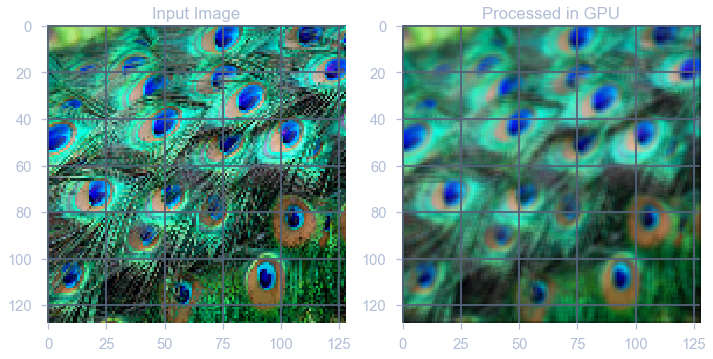

In [84]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1], cmap='gray')
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(outputImage[0][:,:,::-1].astype('uint8'), cmap='gray')
plt.title("Processed in GPU")
plt.tight_layout()
plt.show()